# Computer Vision (CV2022): Assignment 4

### - Avirup Das (MDS202013)


In [2]:
# importing libraries
import cv2
import numpy as np
from skimage import data
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# fetching images
!rm *.jpg *.png
!gdown --id 10Y9iAPfXrN7XZKmpQ8bma84a_EV4yw3j
!unzip histogram_assignment.zip

rm: cannot remove '*.jpg': No such file or directory
rm: cannot remove '*.png': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=10Y9iAPfXrN7XZKmpQ8bma84a_EV4yw3j
To: /content/histogram_assignment.zip
100% 390k/390k [00:00<00:00, 79.9MB/s]
Archive:  histogram_assignment.zip
  inflating: image1.jpg              
  inflating: crayons.jpg             
  inflating: image2.jpg              
  inflating: chestxray1.png          
  inflating: HawkesBay.jpg           


### Helper Functions

In [4]:
# Display Image and Histogram
def image_and_hist(img, title):
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(img, cmap = 'gray')
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].hist(img.flatten(),256,[0,256], color = 'r')
  fig.suptitle(title, fontsize=18)
  plt.show()
  
# Display Intensity Histogram
def intensity_hist(cdf):
  plt.plot(list(range(0,256)),cdf[list(range(0,256))])
  plt.xlabel("Input intensities", fontsize=12)
  plt.ylabel("Output intensities", fontsize=12)
  plt.title("\n\nIntensity transformation due to equalization", fontsize=18)
  plt.show()

# Display single image
def disp_sing(image, title=None, axes=None, cmap=None):
  if cmap is None:
    plt.imshow(image)
  else:
    plt.imshow(image, cmap=cmap)

  if axes is None:
    plt.xticks([])
    plt.yticks([])

  if title is not None:
    plt.title(title, fontsize=18)
  plt.show()


# Display Subplots
def disp_subplots(image, shape, titles, sup_title, axes, figsize, cmap=None):
  fig, ax = plt.subplots(shape[0], shape[1], figsize=figsize)
  try:
    ax = ax.ravel()
  except:
    pass
    
  for i in range(shape[0]*shape[1]):
    if cmap is None:
      ax[i].imshow(image[i])
    else:
      ax[i].imshow(image[i], cmap=cmap)

    if axes[i] is None:
      ax[i].set_xticks([])
      ax[i].set_yticks([])

    if titles[i] is not None:
      ax[i].set_title(titles[i])

  if sup_title is not None:
    fig.suptitle(sup_title, fontsize=18)
  plt.show()
    

# Find nearest above for histogram matching
def find_nearest_above(src, target):
    diff = src - target
    mask = np.ma.less_equal(diff, -1)
    '''
    Masking negative differences 
    since we are looking for values above
    '''
    if np.all(mask):
      '''
      return min index of the nearest if target
       is greater than any value
      '''
      return np.abs(diff).argmin()
    
    masked_diff = np.ma.masked_array(diff, mask)
    return masked_diff.argmin()

## Question 1

In [5]:
def histogram_equalization(image, read_img=True, disp_graph=True, ret_image=False):
  # Reading image as grayscale
  if read_img:
    image = cv2.imread(image,0)
  
  #flattening image array and calculating histogram
  hist, bins = np.histogram(image.flatten(),256,[0,256])
  cdf = hist.cumsum()
  '''  
  finding the minimum histogram value (excluding 0)
   and applying the histogram equalization equation
  '''
  cdf_m = np.ma.masked_equal(cdf,0)
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
  cdf = np.ma.filled(cdf_m,0).astype('uint8')

  if disp_graph:
    
    # Displaying images and histograms
    image_and_hist(image, 'Original Image')
    image_and_hist(cdf[image], 'Histogram Equalized Image')

    # Displaying Intensity Tranformation
    intensity_hist(cdf)
  
    # Comparing results
    eq_image = cv2.equalizeHist(image)
    disp_subplots([cdf[image], eq_image], (1,2), ['Image obtained from manual implementation',
                 'Image obtained using CV2'], '\n\nResult Comparison',[None, None],(12,8),'gray')
  
  if ret_image:
    return cdf[image] 

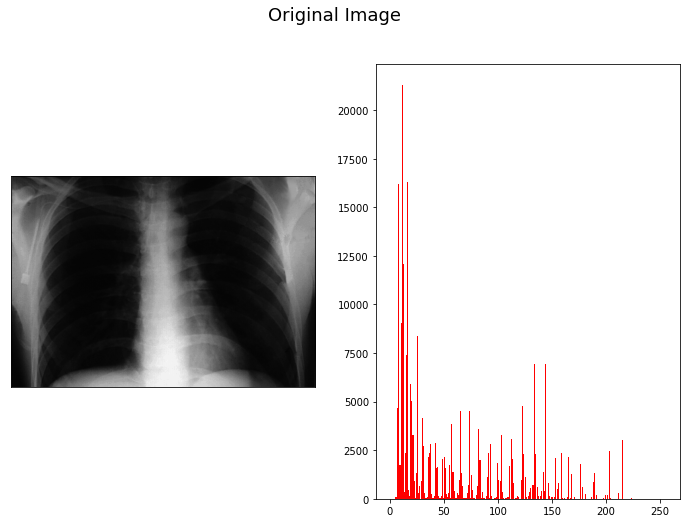

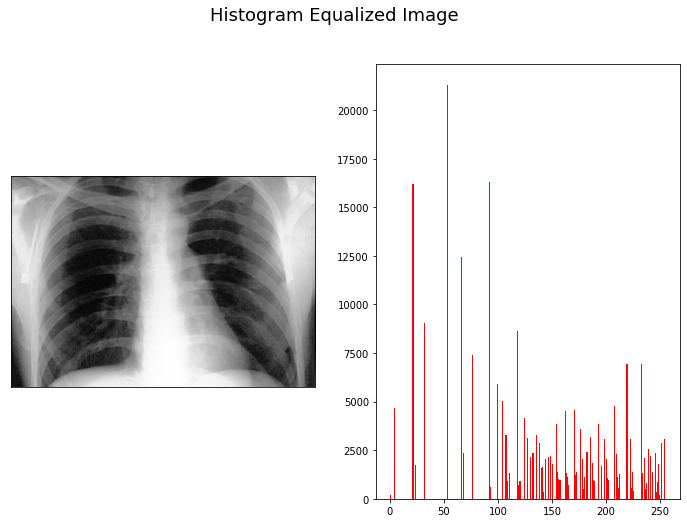

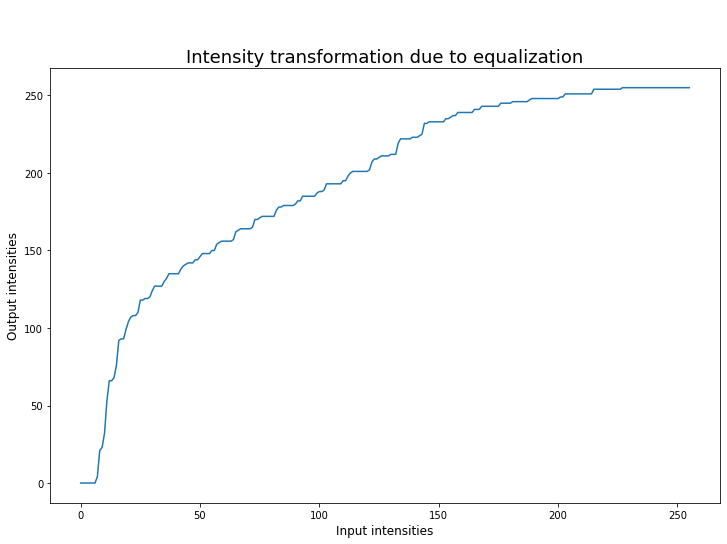

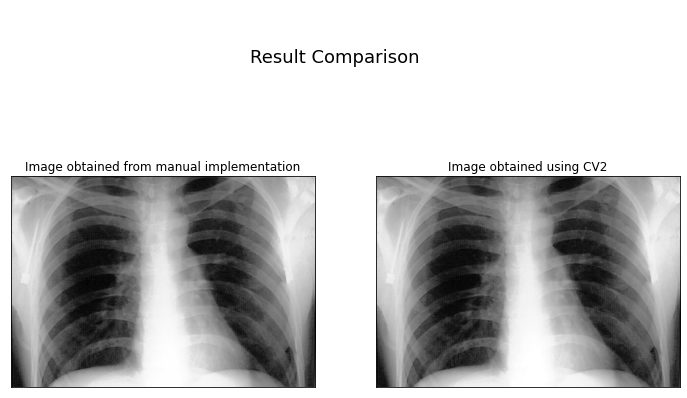

In [6]:
histogram_equalization('chestxray1.png')

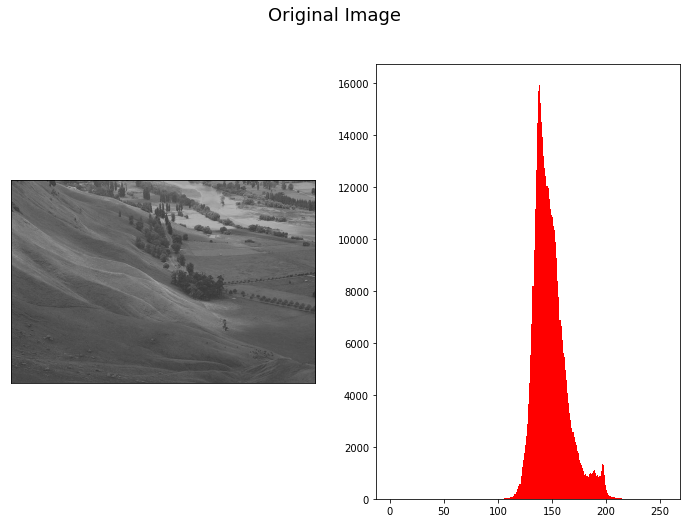

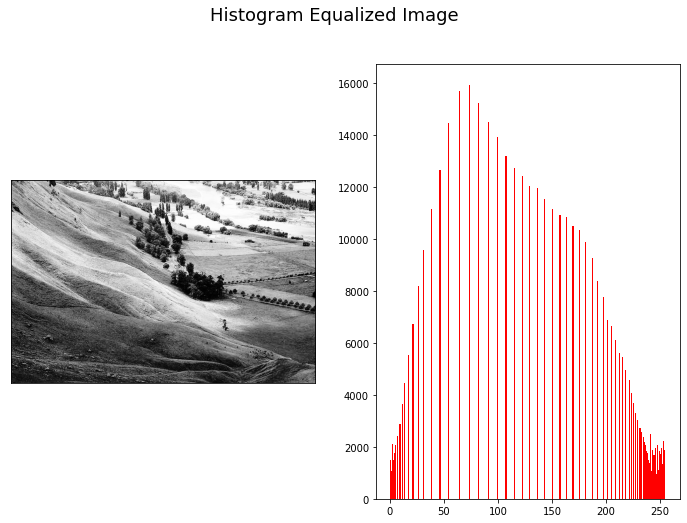

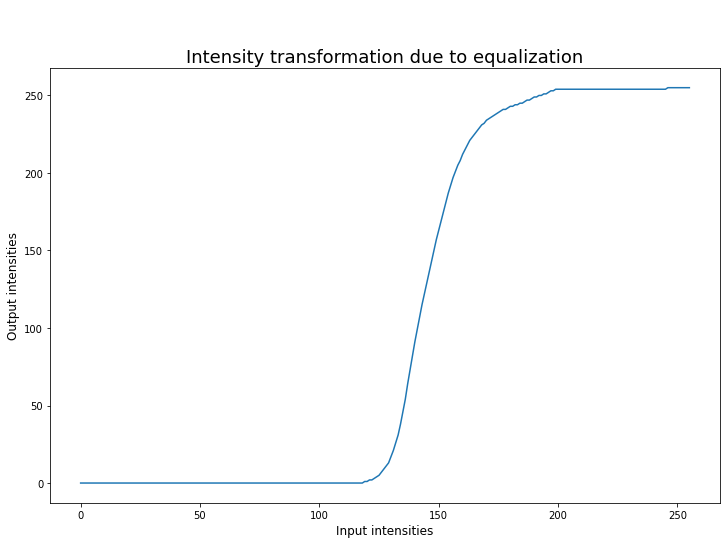

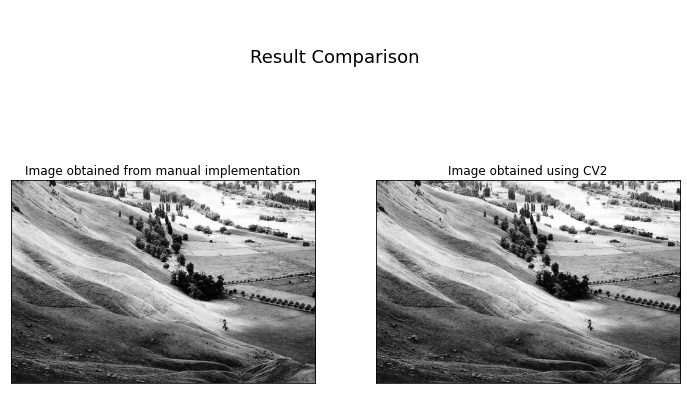

In [7]:
histogram_equalization('HawkesBay.jpg')

From visual inspection we can observe that the images generated from our implementation of histogram equalisation and the pre-defined function available in OpenCV are the same and hence we conclude that our implementation is accurate.

## Question 2

### Part a

In [8]:
def plot_hist_3chan(img):
  # Reading image
  image = cv2.imread(img)
  # Extracting channels
  channels = cv2.split(image)
  color = ['b', 'g', 'r']
  # Generating histograms
  fig, ax = plt.subplots(1,3, figsize=(15,5))
  for i in range(3):
    ax[i].hist(channels[i].flatten(), color=color[i])
    ax[i].set_title(f'Channel-{color[i]} Histogram')
  plt.suptitle(f"Histograms For {img.split('.')[0]}\n\n", fontsize=18)
  plt.show()

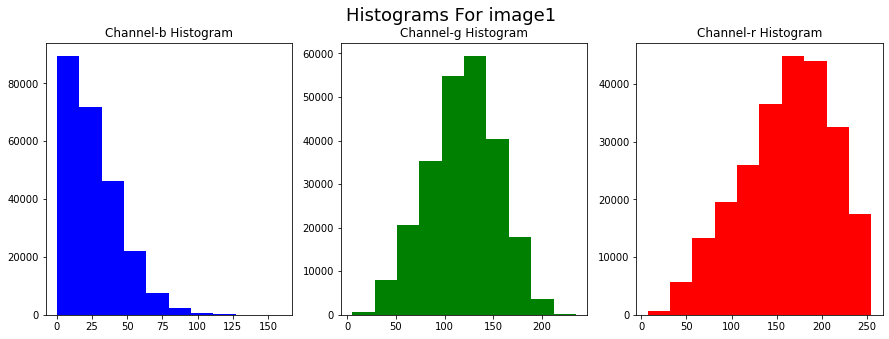

In [9]:
plot_hist_3chan('image1.jpg')

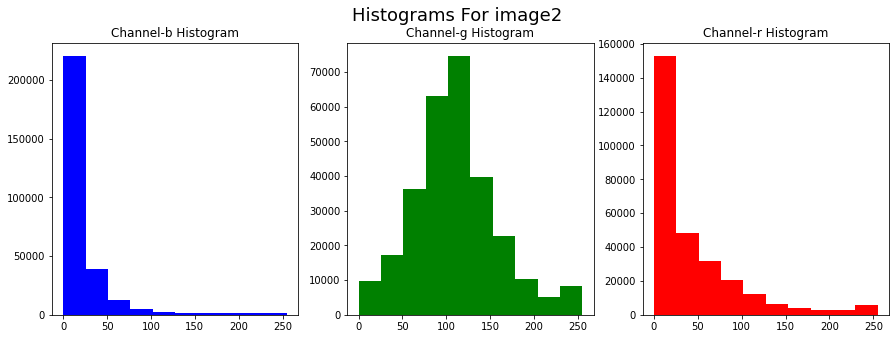

In [10]:
plot_hist_3chan('image2.jpg')

### Part b

In [11]:
def match_hist(src, dst):
    oldshape = src.shape
    src = src.ravel()
    dst = dst.ravel()

    '''
    get the set of unique pixel values and their
     corresponding indices and counts
    '''
    s_values, bin_idx, s_counts = np.unique(src,
                            return_inverse=True,return_counts=True)
    t_values, t_counts = np.unique(dst, return_counts=True)
 
    # Calculate s_k for original image
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    
    # Calculate s_k for specified image
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
 
    # Round the values
    sour = np.around(s_quantiles*255)
    temp = np.around(t_quantiles*255)
    
    # Map the rounded values
    b=[]
    for data in sour[:]:
        b.append(find_nearest_above(temp,data))
    b= np.array(b,dtype='uint8')
 
    return b[bin_idx].reshape(oldshape)

def histogram_matching(img1, img2):
  # Reading images
  img1 = cv2.imread(img1)
  img2 = cv2.imread(img2)

  # Splitting channels from both images
  b_src, g_src, r_src = cv2.split(img1)
  b_dst, g_dst, r_dst = cv2.split(img2)

  # Applying histogram matching to all pairs
  b_new = match_hist(b_src,b_dst)
  g_new = match_hist(g_src,g_dst)
  r_new = match_hist(r_src,r_dst)

  # Merging new channels
  new_img = cv2.merge([b_new,g_new,r_new])

  # Plotting images
  disp_subplots([cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), 
                 cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),
                 cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)],
                 (1,3), ['image1','image2','reconstruced image1'],
                 'Histogram Matching', [None,None,None], (15,5) ,None)

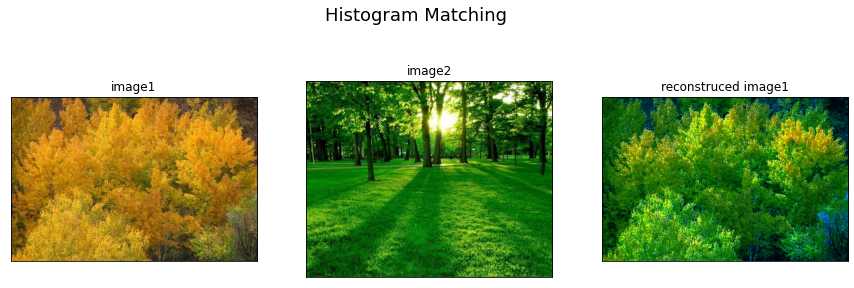

In [12]:
histogram_matching('image1.jpg','image2.jpg')

###Part c
 From the above outputs we can clearly observe that 'image1', which was dominated by shades of yellow, has become 'greener' after reconstruction since 'image2' is dominated by the green color.

## Question 3

### Part a

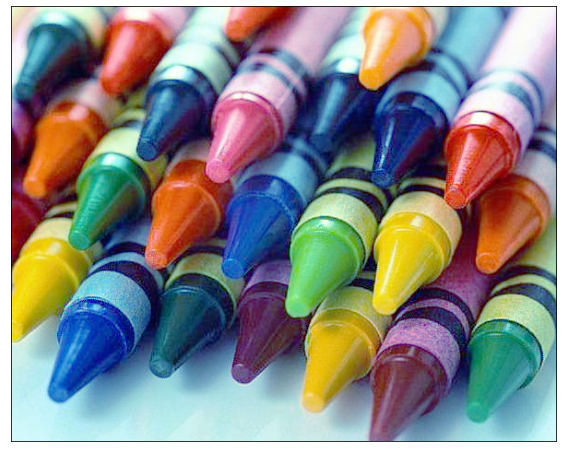

In [13]:
# Reading crayons image
image = cv2.imread('crayons.jpg')

#splitting the images into three color channels
channels = cv2.split(image)

#applying histogram equalization on each channel
eq_ch = []
for ch in channels:
  eq_ch.append(histogram_equalization(ch, read_img=False,
                            disp_graph=False, ret_image=True))

#merging the equalized channels together again    
eq_image = cv2.merge(eq_ch)

#plotting the new image
eq_image = cv2.cvtColor(eq_image, cv2.COLOR_BGR2RGB)
disp_sing(eq_image, cmap='gray')

### Part b

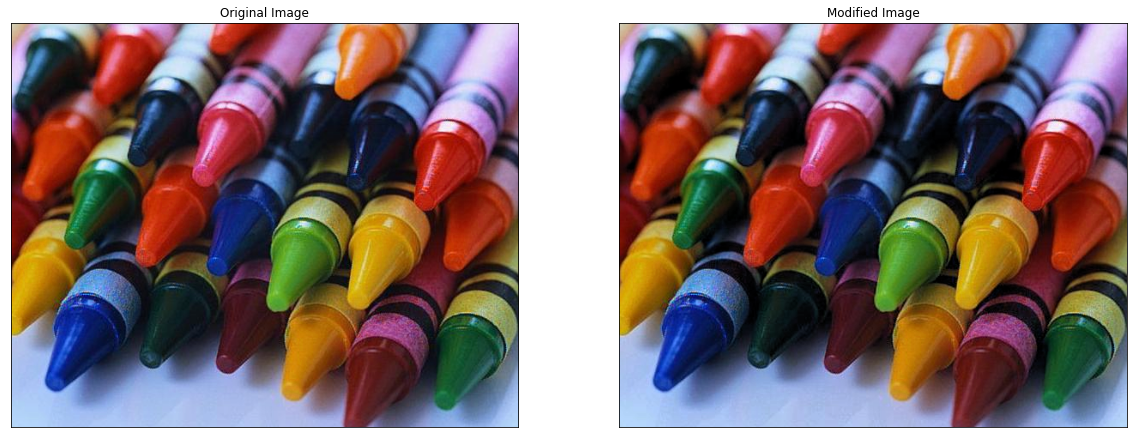

In [14]:
# Converting image to hsv format
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Extracting channels 'h','s' and 'v'
channels = cv2.split(hsv)

# Equalizing the channel 'v'
new_v = histogram_equalization(channels[2], read_img=False,
                            disp_graph=False, ret_image=True)

# Merging new channel v with unchanged h and s
new_image = cv2.merge((channels[0],channels[1],new_v))

# Displaying
disp_subplots([cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)],
              (1,2), ['Original Image','Modified Image'],None,[None, None],(20,12),'gray')

### Part c

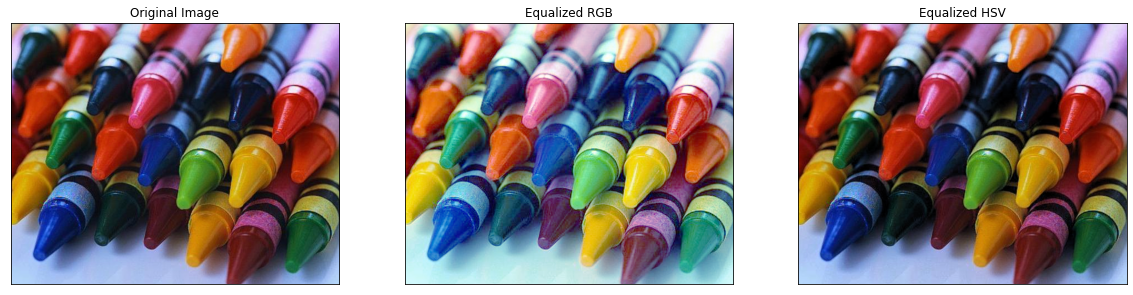

In [15]:
# Comparing results from part a and b
disp_subplots([cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), eq_image,
               cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)], (1,3),
               ['Original Image', 'Equalized RGB','Equalized HSV'],
               None,[None, None, None],(20,12),'gray')

As we can see, the method applied in part a, i.e. equalizing the RGB channels individually and recombining them, makes the image brighter to some extent. While on the other hand, when we use the method in part b, i.e. equalizing the V (value) channel of the HSV version of the image and then recombine it with other channels (unchanged H and S), the converted image looks similar to the original image.

## Question 4

### Part a

In [16]:
#importing the image
img = data.camera()

#taking inputs from the user
while True:
  try:
    k=int(input("Enter an odd integer for the neighbourhood size (k): "))
    if k%2==0:
      k=k/0
  except:
    print('Please enter an odd integer')
    continue
  else:
    break

#x1,x2,y1,y2 defines the region over which we want to apply histogram equalization
print("Please specify the region of the image  to be equalized\n")
x1 = int(input("Enter x1, the starting row number: "))
x2 = int(input("Enter x2, the ending row number: "))
y1 = int(input("Enter y1, the starting column number: "))
y2 = int(input("Enter y2, the ending column number: "))

Enter an odd integer for the neighbourhood size (k): 2
Please enter an odd integer
Enter an odd integer for the neighbourhood size (k): 3
Please specify the region of the image  to be equalized

Enter x1, the starting row number: 0
Enter x2, the ending row number: 512
Enter y1, the starting column number: 0
Enter y2, the ending column number: 512


### Part b
We now slide the neighbourhood horizontally over the center pixels and use the updating method to carry out equalization.

100%|██████████| 509/509 [02:30<00:00,  3.39it/s]


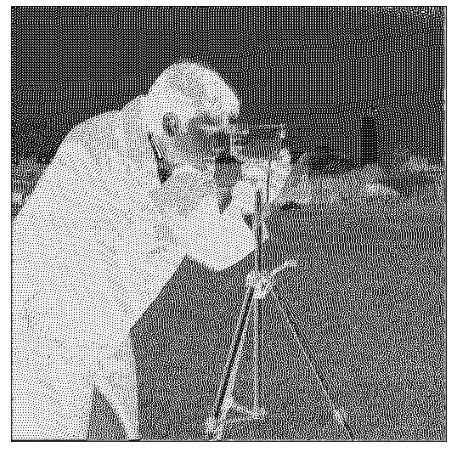

In [17]:
img1 = img.copy()
for j in tqdm(range(x1,x2-k,1)):
  for i in range(y1,y2-k,1):
    img1[i:i+k, j:j+k] = histogram_equalization(img1[i:i+k, j:j+k],
                                        read_img=False, disp_graph=False,
                                        ret_image=True)
# Displaying equalized image
disp_sing(img1, cmap='gray')

### Part c 
Now we break up the image into 'blocks' or 'tiles' of suitable size and apply histogram equalization on each block separately. Then we combine these blocks to create the entire image.

100%|██████████| 9/9 [00:00<00:00, 158.83it/s]


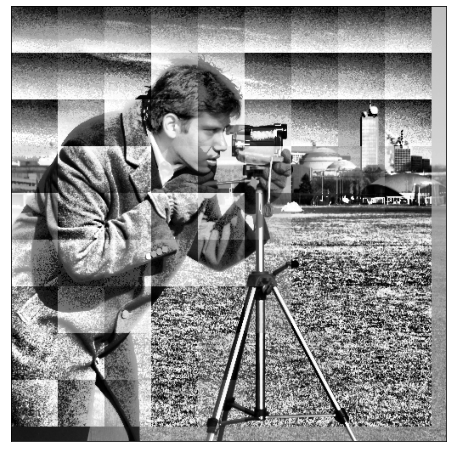

In [18]:
# block size
k = 55
# number of steps the slide is advancing in each turn
s = k  
'''
Here we have kept this same as k, as here we are dividing the 
whole image into blocks and doing the equilization on each block
'''
x1, y1 = 0, 0
x2, y2 = img.shape

img2 = img.copy()
for j in tqdm(range(x1,x2-k,s)):
  for i in range(y1,y2-k,s):
    '''
    applying histogram equalization on each block separately
    and then combining these blocks to create the entire image
    '''
    img2[i:i+k, j:j+k] = histogram_equalization(img2[i:i+k, j:j+k],
                                        read_img=False, disp_graph=False,
                                        ret_image=True)
        
# Displaying combined image
disp_sing(img2, cmap='gray')

### Part d

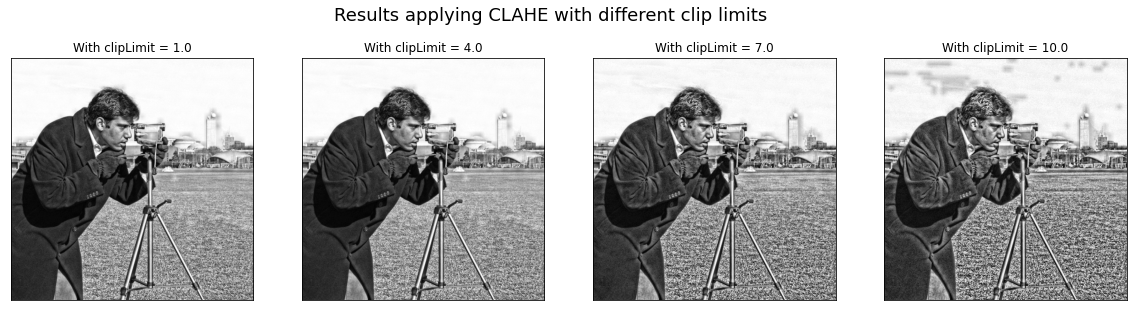

In [19]:
#applying CLAHE with different clip limits

images, cl, titles = [], [], []
for i in range(1,11,3):
  cl.append(cv2.createCLAHE(clipLimit= i, tileGridSize=(55,55)))
  images.append(cl[-1].apply(img))
  titles.append(f"\nWith clipLimit = {float(i)}")
disp_subplots(images, (1,4), titles,
              "Results applying CLAHE with different clip limits\n",
              [None]*4, (20,5), cmap='gray')

### Part e
Comparing the above two methods, i.e.,  SWAHE and CLAHE based on the image results:

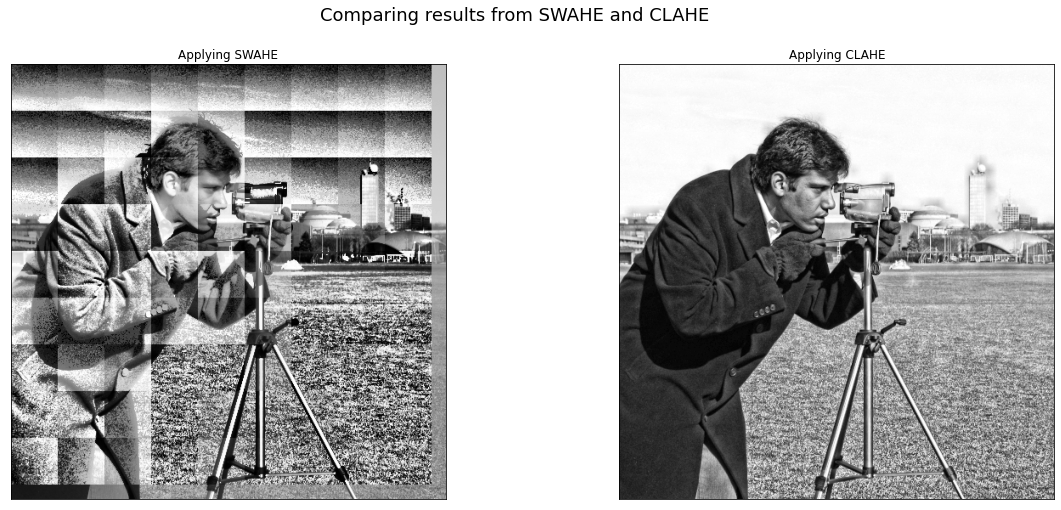

In [20]:
disp_subplots([img2, images[0]], (1,2), ["\nApplying SWAHE", "\nApplying CLAHE"],
              "Comparing results from SWAHE and CLAHE\n",
              [None]*2, (20,8), cmap='gray')

We observe that the CLAHE method works significantly better than SWAHE on our image.

## Question 5

We would use chestxray for this task

### Part a

In [ ]:
def intensity_slicing_1(img, min_range, max_range):
  row, column = img.shape
  # Creating an array with zeroes to store the sliced image
  img1 = np.zeros((row,column),dtype = 'uint8')

  #performing intensity slicing as asked in part (a)    
  for i in range(row):
    for j in range(column):
      if img[i,j]>min_range and img[i,j]<max_range:
        img1[i,j] = 255
      else:
        img1[i,j] = 0

  return img1

### Part b

In [ ]:
def intensity_slicing_2(img, min_range, max_range):
  row, column = img.shape
  # Creating an array with zeroes to store the sliced image
  img1 = np.zeros((row,column),dtype = 'uint8')

  #performing intensity slicing as asked in part (b)    
  for i in range(row):
    for j in range(column):
      if img[i,j]>min_range and img[i,j]<max_range:
        img1[i,j] = 255
      else:
        img1[i,j] = img[i,j]

  return img1

### Comparison

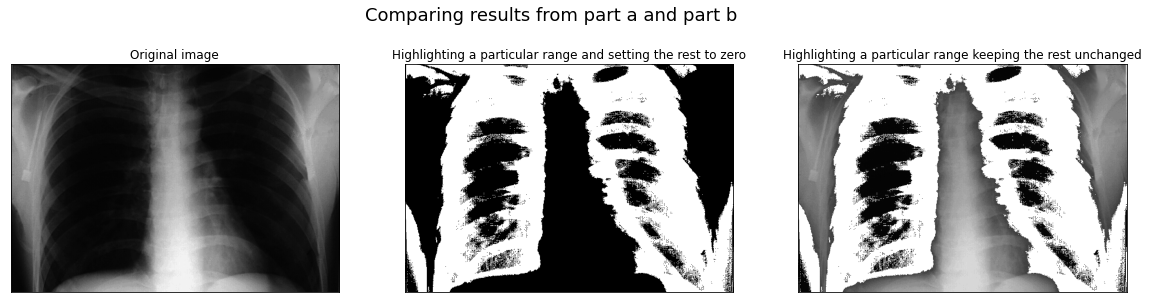

In [ ]:
# Reading chest x-ray image
img = cv2.imread('chestxray1.png',0)

# Specify the min and max range
min_range = 10
max_range = 60

# Applying intensity slicing
images = [img, intensity_slicing_1(img, min_range, max_range),
          intensity_slicing_2(img, min_range, max_range)]

# Displaying results
disp_subplots(images, (1,3), ["Original image",
                              "Highlighting a particular range and setting the rest to zero",
                              "Highlighting a particular range keeping the rest unchanged"],
              "Comparing results from part a and part b\n",
              [None]*3, (20,5), cmap='gray')

## Question 6

In [ ]:
# Loading image
img = data.camera()

'''
Iterating over each pixel and change pixel value to binary
 using np.binary_repr() and storing it in a list
'''
lst = list()
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    # Here width = number of bits
    lst.append(np.binary_repr(img[i][j], width=8))

images = np.zeros((8, img.shape[0],img.shape[1]), np.uint8)

for j in range(0,8):
    b = 2**j
    images[j] = (np.array([int(i[7-j]) for i in lst],dtype = np.uint8)*b).reshape(img.shape[0],img.shape[1])

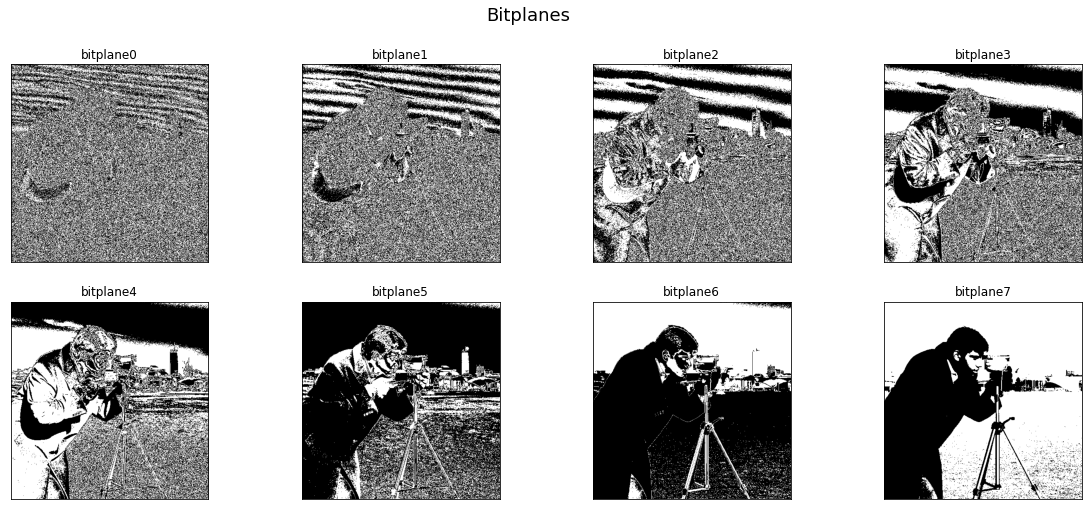

In [ ]:
titles, imgs = [], []
for i in range(8):
  imgs.append(images[i]/np.max(images[i])*255)
  titles.append(f'bitplane{i}')

# Displaying 8 bitplanes
disp_subplots(imgs, (2,4), titles, "Bitplanes\n",
              [None]*8, (20,8), cmap='gray')

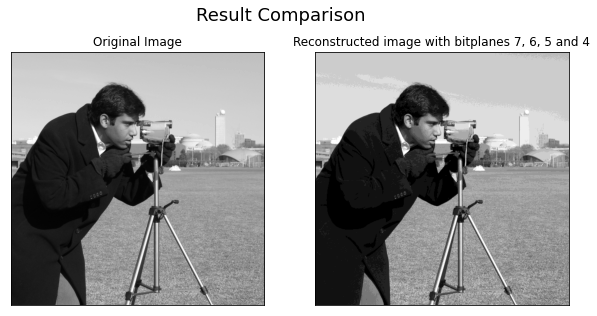

In [ ]:
#reconstructing image with fewer bitplanes
new_img = images[7]+images[6]+images[5]+images[4]

# Comparing results
disp_subplots([img, new_img], (1,2), ['Original Image',
              'Reconstructed image with bitplanes 7, 6, 5 and 4'], "Result Comparison\n",
              [None]*2, (10,5), cmap='gray')